Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime, date

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Считываем и изучаем данные

In [2]:
reg_data = pd.read_csv('C:/Users/makog/KC lessons/jupyter-s-makogon _from_KC/shared/problem1-reg_data.csv', sep=';')

In [3]:
reg_data.tail()

,reg_ts,uid
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621
999999,1600874244,1110622


In [4]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [5]:
reg_data.duplicated().sum()

0

In [6]:
reg_data['uid'].nunique()

1000000

In [7]:
auth_data = pd.read_csv('C:/Users/makog/KC lessons/jupyter-s-makogon _from_KC/shared/problem1-auth_data.csv', sep=';')

In [8]:
auth_data.shape

(9601013, 2)

In [9]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [10]:
auth_data.duplicated().sum()

0

In [11]:
reg_data['uid'].nunique()

1000000

In [12]:
# Проверим, нет ли среди пользователей тех, кто по какой-либо причине пропустил регистрацию - нет

uid_reg = reg_data['uid'].unique()
auth_data.query('uid not in @uid_reg').shape[0]

0

In [13]:
# Очевидно, вермя в Unix формате. Преобразуем:

reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date

In [14]:
print(reg_data['reg_ts'].min())
print(reg_data['reg_ts'].max())

1998-11-18
2020-09-23


<AxesSubplot:>

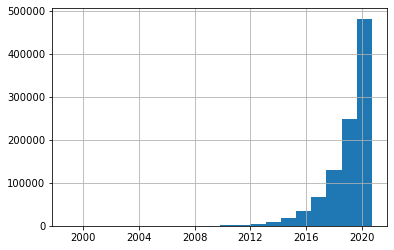

In [15]:
# Посмотрим на распределение временного ряда - наше приложение на рынке уже более 20 лет, 
# кол-во регистраций экспоненциально растет

reg_data['reg_ts'].hist(bins=20)

In [16]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date

In [17]:
print(auth_data['auth_ts'].min())
print(auth_data['auth_ts'].max())

1998-11-18
2020-09-23


<AxesSubplot:>

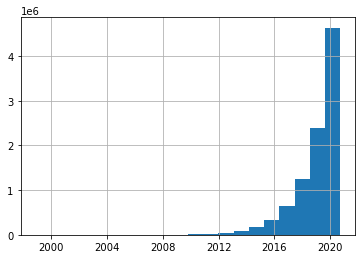

In [18]:
# Распределение данных по авторизациям согласуется с регистрацией

auth_data['auth_ts'].hist(bins=20)

In [19]:
# Поджойним датасеты, используя inner join, т.к. в задаче обязательное условие - пользователь 
# д.б. зарегистрирован, хотя в нашем случае это выполняется на уровне данных

df_all = auth_data.merge(reg_data, on='uid', how='inner')
df_all.shape

(9601013, 3)

In [20]:
df_all.head()

,auth_ts,uid,reg_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22
3,1999-07-31,2,1999-07-22
4,1999-08-05,2,1999-07-22


In [21]:
# В датасете нет повторных авторизаций в игре в день регистрации

df_all[df_all['reg_ts'] == df_all['auth_ts']]['uid'].value_counts(ascending=True)

1          1
740367     1
740369     1
740370     1
740371     1
          ..
370253     1
370254     1
370255     1
370257     1
1110622    1
Name: uid, Length: 1000000, dtype: int64

In [22]:
# Более того, в датасете в течении дня только одна авторизация

df_all.groupby(['uid', 'auth_ts'], as_index=False)['reg_ts'].count().sort_values('reg_ts')

,uid,auth_ts,reg_ts
0,1,1998-11-18,1
6400671,416581,2020-05-10,1
6400672,416581,2020-05-12,1
6400673,416581,2020-05-13,1
6400674,416581,2020-05-16,1
...,...,...,...
3200338,141058,2018-12-13,1
3200339,141058,2018-12-19,1
3200340,141058,2018-12-26,1
3200324,141058,2018-10-14,1


Retention – главный показатель удержания пользователей.

В индустрии мобильных игр и приложений Retention обычно считают на N-день со дня первого взаимодействия с продуктом.

Например,

Day 0 Retention – доля пользователей, совершавших второй вход в проект в течение суток после первого.
(в нашем случае невозможно рассчитать, т.к. данные повторных визитов в течении суток отсутствуют)
 
Day 1 Retention – доля пользователей, входивших в проект через 1 день после первого визита.

Day 7 Retention – доля пользователей, входивших в проект через 7 дней после первого визита.

Day 30 Retention – доля пользователей, входивших в проект через 30 дней после первого визита.

Наши данные содержат сведения более чем за 20 лет, что конечно круто, но для менеджера едва ли потребуется считать устаревшие метрики. От нас в задании требуется написать функцию, которая будет считать retention игроков. Полагаю, будет полезным предусмотреть возможность пользовательской настройки временных периодов.

In [23]:
# Введите дату начала и конца периода в формате <YYYY-MM-DD>

date_start = pd.to_datetime(str(input('Введите дату начала периода в формате YYYY-MM-DD: '))).date()
date_end = pd.to_datetime(str(input('Введите дату окончания периода в формате YYYY-MM-DD: '))).date()

Введите дату начала периода в формате YYYY-MM-DD: 2020-07-01
Введите дату окончания периода в формате YYYY-MM-DD: 2020-07-15


In [24]:
# Отберем пользователей, зарегистрировавшихся в требуемых период

reg_data_subset = reg_data.query("@date_start <= reg_ts <= @date_end")

In [25]:
reg_data_subset

,reg_ts,uid
870076,2020-07-01,966268
870077,2020-07-01,966269
870078,2020-07-01,966270
870079,2020-07-01,966271
870080,2020-07-01,966272
...,...,...
891799,2020-07-15,990462
891800,2020-07-15,990463
891801,2020-07-15,990464
891802,2020-07-15,990465


In [26]:
df_period = auth_data.merge(reg_data_subset, on='uid', how='inner')

In [27]:
df_period

,auth_ts,uid,reg_ts
0,2020-07-01,966268,2020-07-01
1,2020-07-01,966269,2020-07-01
2,2020-07-01,966270,2020-07-01
3,2020-07-01,966271,2020-07-01
4,2020-07-01,966272,2020-07-01
...,...,...,...
65907,2020-08-04,990463,2020-07-15
65908,2020-08-05,990463,2020-07-15
65909,2020-07-15,990464,2020-07-15
65910,2020-07-15,990465,2020-07-15


In [28]:
# В нашем случае когортой пользователей будет день регистрации 'reg_ts'

df_cohort = df_period.groupby(['reg_ts', 'auth_ts'], as_index=False)\
                    .agg({'uid': 'nunique'})\
                    .rename(columns={'uid': 'num_users'})

In [29]:
# Посчитаем разницу в днях между авторизацией и регистрацией

df_cohort['days_dif'] = df_cohort['auth_ts'] - df_cohort['reg_ts']
df_cohort['days_dif'] = df_cohort['days_dif'].dt.days

In [30]:
# Предоставим возможность задавать количество дней для retention

days_limit = int(input('Введите верхнюю границу дней для retention: '))

df_cohort = df_cohort[df_cohort['days_dif'] <= days_limit]

Введите верхнюю границу дней для retention: 15


In [31]:
df_cohort.head(20)

,reg_ts,auth_ts,num_users,days_dif
0,2020-07-01,2020-07-01,1432,0
1,2020-07-01,2020-07-02,27,1
2,2020-07-01,2020-07-03,66,2
3,2020-07-01,2020-07-04,63,3
4,2020-07-01,2020-07-05,80,4
5,2020-07-01,2020-07-06,89,5
6,2020-07-01,2020-07-07,97,6
7,2020-07-01,2020-07-08,98,7
8,2020-07-01,2020-07-09,70,8
9,2020-07-01,2020-07-10,77,9


In [32]:
cohort_pivot = df_cohort.pivot_table(index='reg_ts', columns='days_dif', values='num_users')

In [33]:
# Получили косынку с абсолютными значениями - кол-во пользователей, заходивших в приложение по дням

cohort_pivot

days_dif,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
reg_ts,,,,,,,,,,,,,,,,
2020-07-01,1432,27,66,63,80,89,97,98,70,77,69,67,69,76,66,72
2020-07-02,1434,36,57,82,64,97,97,77,89,63,77,71,78,72,63,71
2020-07-03,1437,30,59,69,73,80,92,96,74,80,78,73,75,84,70,73
2020-07-04,1439,32,72,62,89,92,91,96,72,75,73,69,80,75,67,62
2020-07-05,1441,32,61,59,74,94,106,80,70,78,80,90,59,72,67,67
2020-07-06,1444,29,44,81,81,83,86,87,68,63,60,83,69,73,72,54
2020-07-07,1446,22,56,66,71,92,99,95,68,78,81,72,75,90,62,60
2020-07-08,1449,35,63,58,86,72,106,68,68,71,87,59,53,84,56,77
2020-07-09,1450,28,64,87,63,92,108,104,66,79,67,80,82,82,72,66


In [34]:
# Для расчета ретеншена необходимо разделить на общее кол-во зарегистрированнх за день пользователей 

cohort_size = cohort_pivot[0]
retention_df = cohort_pivot.divide(cohort_size, axis=0).mul(100).round(2)

In [35]:
retention_df

days_dif,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
reg_ts,,,,,,,,,,,,,,,,
2020-07-01,100.0,1.89,4.61,4.40,5.59,6.22,6.77,6.84,4.89,5.38,4.82,4.68,4.82,5.31,4.61,5.03
2020-07-02,100.0,2.51,3.97,5.72,4.46,6.76,6.76,5.37,6.21,4.39,5.37,4.95,5.44,5.02,4.39,4.95
2020-07-03,100.0,2.09,4.11,4.80,5.08,5.57,6.40,6.68,5.15,5.57,5.43,5.08,5.22,5.85,4.87,5.08
2020-07-04,100.0,2.22,5.00,4.31,6.18,6.39,6.32,6.67,5.00,5.21,5.07,4.79,5.56,5.21,4.66,4.31
2020-07-05,100.0,2.22,4.23,4.09,5.14,6.52,7.36,5.55,4.86,5.41,5.55,6.25,4.09,5.00,4.65,4.65
2020-07-06,100.0,2.01,3.05,5.61,5.61,5.75,5.96,6.02,4.71,4.36,4.16,5.75,4.78,5.06,4.99,3.74
2020-07-07,100.0,1.52,3.87,4.56,4.91,6.36,6.85,6.57,4.70,5.39,5.60,4.98,5.19,6.22,4.29,4.15
2020-07-08,100.0,2.42,4.35,4.00,5.94,4.97,7.32,4.69,4.69,4.90,6.00,4.07,3.66,5.80,3.86,5.31
2020-07-09,100.0,1.93,4.41,6.00,4.34,6.34,7.45,7.17,4.55,5.45,4.62,5.52,5.66,5.66,4.97,4.55


Соберем скрипт в функцию calculate_RR и упакуем в одноименный модуль. 

Проверим работоспособность и визуализируем результат

In [2]:
from calculate_RR import calculate_RR

In [3]:
a = 'C:/Users/makog/KC lessons/jupyter-s-makogon _from_KC/shared/problem1-reg_data.csv'
b = 'C:/Users/makog/KC lessons/jupyter-s-makogon _from_KC/shared/problem1-auth_data.csv'

df = calculate_RR(a, b)

Введите дату начала периода в формате YYYY-MM-DD: 2020-07-01
Введите дату окончания периода в формате YYYY-MM-DD: 2020-07-15
Введите верхнюю границу количества дней retention: 15


<AxesSubplot:xlabel='days_dif', ylabel='reg_ts'>

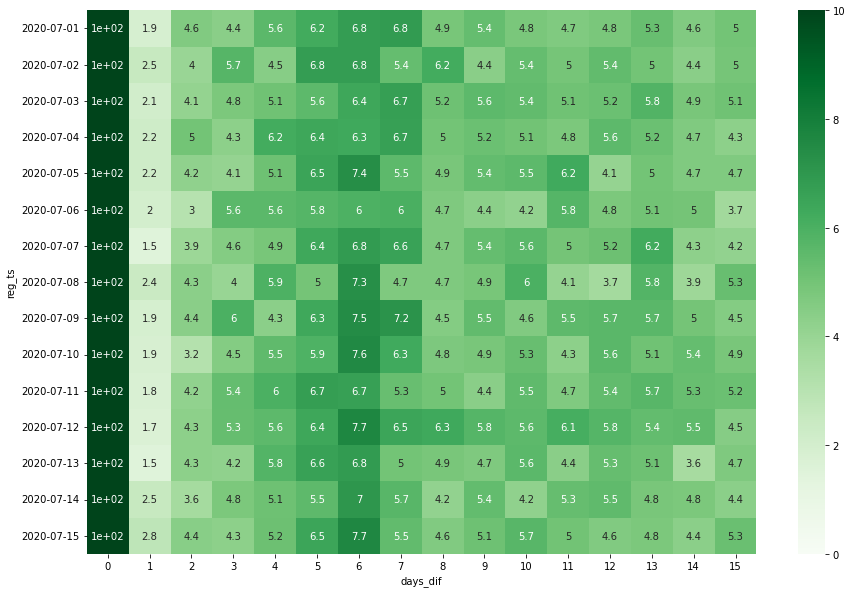

In [4]:
# По классике построим хитмэм для наглядности

fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(df, vmin=0, vmax=10, cmap="Greens", annot=True, ax=ax)

Предложу еще одну визуализацию для сравнения средних ретеншен по дням за разные периоды

In [40]:
# Получаем второй ретеншен-дф с другим периодом для сравнения с первым

a = 'C:/Users/makog/KC lessons/jupyter-s-makogon _from_KC/shared/problem1-reg_data.csv'
b = 'C:/Users/makog/KC lessons/jupyter-s-makogon _from_KC/shared/problem1-auth_data.csv'

df_2 = calculate_RR(a, b)

Введите дату начала периода в формате YYYY-MM-DD: 2020-07-16
Введите дату окончания периода в формате YYYY-MM-DD: 2020-07-30
Введите верхнюю границу количества дней retention: 15


In [41]:
# Функция формирования дф со средним ретеншен по каждому дню

def retention_mean(df): 
    r_mean = {}

    for i in range(1, df.shape[1]):
        r_mean[i] = round(df[i].mean(), 2)

    return pd.DataFrame(r_mean.items(), columns=['day', 'retention_mean'])

In [42]:
df_mean = retention_mean(df)
df_mean_2 = retention_mean(df_2)

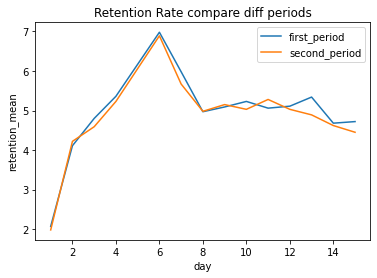

In [43]:
first_period = sns.lineplot(x= 'day', y='retention_mean', data= df_mean, palette = 'blue', label = 'first_period') 
second_period = sns.lineplot(x= 'day', y='retention_mean', data= df_mean_2, palette = 'orange', label = 'second_period')
plt.title("Retention Rate compare diff periods")
plt.legend()
plt.show()